# Moon Crater Detection

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
import numpy as np

# Disable pixel limit for crater images
Image.MAX_IMAGE_PIXELS = None

#### Gather Tiff Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

#Change Folder to access your data
#folder = '/content/drive/My Drive/Physics 361/Final Project/cropped_craters' #Evan
folder = '/content/drive/My Drive/PHY361/Physics Final Project/cropped_craters' #Ferris

tiff_files = glob.glob(os.path.join(folder, "*.tiff"))
train_files, test_files = train_test_split(tiff_files, test_size=0.2, random_state=42)

Mounted at /content/drive


#Choose feedforward parameters

In [ ]:
# Columns:
# Radius, Transient cavity diameter [km], Floor diameter [km], Rim to floor depth [km], Apparent depth [km],
# Interior volume [km^3], Rim flank width [km], Height of central peak [km]	Age

# JONATHAN RUN THIS params = ["Radius", "Apparent depth [km]"]
# ADAM RUN THIS params = ["Radius", "Transient cavity diameter [km]", "Floor diameter [km]", "Rim to floor depth [km]", "Apparent depth [km]", "Interior volume [km^3]", "Rim flank width [km]", "Height of central peak [km]"]
num_params = len(params)

# Building Model From Components

In [ ]:
class CraterCNN(nn.Module):
    """
    Example CNN that returns a 128-d embedding instead of class logits.
    (Modified from your CraterNet to remove the final classification layer.)
    """
    def __init__(self, embed_dim=128, dropout_rate=0.25):
        super().__init__()
        # Convolutions/pooling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Calculate the correct input size for fc1
        # Assuming input image size is 512x512
        self.fc_input_size = self._get_fc_input_size(512, 512)
        self.fc1 = nn.Linear(self.fc_input_size, embed_dim) # Fixed: using dynamically calculated input size
        self.dropout_fc = nn.Dropout(dropout_rate)


    def _get_fc_input_size(self, height, width):
        """Calculates the input size for the fully connected layer."""
        x = torch.randn(1, 1, height, width) # create a dummy input
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        return x.view(1, -1).shape[1]  # return the flattened size

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Output embedding
        x = F.relu(self.fc1(x))  # shape (batch_size, embed_dim)
        x = self.dropout_fc(x)
        return x

class ParamNet(nn.Module):
    """
    A simple feedforward net for crater radius (or other numeric features).
    """
    def __init__(self, num_params=num_params, embed_dim=8, dropout_rate=0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_params, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

    def forward(self, x):
        # x: (batch_size)
        return self.net(x)  # (batch_size, embed_dim)

class CraterAgeNet(nn.Module):
    """
    Full pipeline:
    - CNN -> 1D embedding
    - ParamNet -> 1D embedding
    - Concatenate them -> final classifier for Age
    """
    def __init__(self,
                 cnn_embed_dim=128,    # dimension from CNN
                 radius_embed_dim=8,   # dimension from radius net
                 num_params=num_params,
                 num_classes=6,        # e.g., if we have 6 age categories
                 dropout_rate=0.25):
        super().__init__()

        self.cnn = CraterCNN(embed_dim=cnn_embed_dim)
        self.radius_net = ParamNet(num_params=num_params,embed_dim=radius_embed_dim)

        fused_dim = cnn_embed_dim + radius_embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, num_classes),
        )

    def forward(self, images, radius):
        """
        images: shape (batch_size, 1, H, W)
        radius: shape (batch_size, 1)
        returns: shape (batch_size, num_classes)
        """
        cnn_feat = self.cnn(images)            # (batch_size, cnn_embed_dim)
        radius_feat = self.radius_net(radius)  # (batch_size, radius_embed_dim)

        fused = torch.cat([cnn_feat, radius_feat], dim=1)  # (batch_size, fused_dim)
        logits = self.classifier(fused)
        return logits

In [ ]:
class MoonCraterDataset(Dataset):
    def __init__(self, image_paths, params_dict, labels_dict, transform=None):
        self.image_paths = image_paths
        self.df = df
        self.transform = transform
        self.params_dict = params_dict
        self.labels_dict = labels_dict

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        # Suppose the crater name is part of the file name or can be extracted
        crater_name = img_path.split("/")[-1][:-5].replace("_", " ").replace("'", " ")

        # get params
        item_params = self.params_dict[crater_name]

        # get label
        # label
        label = self.labels_dict[crater_name]

        # radius needs to be a tensor of shape (num_params,)
        params_tensor = torch.tensor(item_params, dtype=torch.float)

        return image, params_tensor, label


In [ ]:
def train_crater_age_model(model, train_loader, test_loader, num_epochs=5, lr=1e-3):
    train_accuracies = []
    test_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()  # for multi-class classification
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(f"Training on device: {device}")
    start = time()
    for epoch in range(num_epochs):
        epoch_time = time()
        model.train()
        running_loss = 0.0

        for images, _params, labels in train_loader:
            images = images.to(device)        # shape: (batch_size, 1, H, W)
            _params = _params.to(device)        # shape: (batch_size, 1)
            labels = labels.to(device)        # shape: (batch_size,)

            optimizer.zero_grad()

            # Forward pass
            logits = model(images, _params)    # (batch_size, num_classes)
            loss = criterion(logits, labels)

            # Backprop
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # --- Evaluate on training set ---
        print("Evaluating on TRAIN set:", end = " ")
        _, _, train_score = evaluate_model(model, train_loader)
        train_accuracies.append(train_score)

        # --- Evaluate on test set ---
        print("Evaluating on TEST set:", end = " ")
        _, _, test_score = evaluate_model(model, test_loader)
        test_accuracies.append(test_score)

        torch.save(model.state_dict(), f"combined_crater_age_net{trial_num}_epoch{epoch}.pth")
        print("Model saved.")
        print(f"Epoch time: {((time() - epoch_time)/60):.2f}m")
        print(f"Elapsed Time: {((time() - start)/60):.2f}m")
        print("------------")

    return model, train_accuracies, test_accuracies


In [ ]:
def evaluate_model(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    total = 0
    correct = 0

    # Optionally collect all predictions/labels for more advanced metrics
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for images, _params, labels in val_loader:
            images, _params, labels = images.to(device), _params.to(device), labels.to(device)

            outputs = model(images, _params)  # shape (batch_size, num_classes)
            preds = outputs.argmax(dim=1)       # get predicted class indices

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

    return all_preds, all_labels, accuracy


In [ ]:
ages = {"pre-Nectarian": 0,
        "Nectarian": 1,
        "Lower Imbrian": 2,
        "Upper Imbrian": 3,
        "Eratosthenian": 4,
        "Copernican": 5
        }


# Transformation on Image
transform = T.Compose([
    T.Resize((512, 512)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor()
])


# Create radius_dict from filter.csv, label_dict from the same or another CSV
# Example pseudo-code:

params_dict = {}  # crater_name -> float radius
labels_dict = {}  # crater_name -> int label index

#Change location depending on where filtered.csv is
df = pd.read_csv("/content/drive/My Drive/PHY361/Physics Final Project/filtered.csv") #Ferris
#df = pd.read_csv("/content/drive/My Drive/Physics 361/Final Project/filtered.csv") #Evan

for i, row in df.iterrows():
    crater_name = row["Name"]
    params_dict[crater_name] = []
    for param in params:
        params_dict[crater_name].append(float(row[param]))
    # Convert Age to integer class
    labels_dict[crater_name] = ages[row["Age"].strip()]

# Now build the dataset
train_dataset = MoonCraterDataset(
    image_paths=train_files,
    params_dict=params_dict,
    labels_dict=labels_dict,
    transform=transform
)

test_dataset = MoonCraterDataset(
    image_paths=test_files,
    params_dict=params_dict,
    labels_dict=labels_dict,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=4, shuffle=False)



In [ ]:
# Training Model:
#1 Epoch is roughly 5 minutes
trial_num = "8"
epochs = 100
combined_model = CraterAgeNet(cnn_embed_dim=128, radius_embed_dim=8, num_classes=6)
trained_combined_model, train_accuracies, test_accuracies = train_crater_age_model(
    model=combined_model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=epochs,
    lr=1e-3
)

torch.save(trained_combined_model.state_dict(), f"combined_crater_age_net{trial_num}.pth")
np.save(f'train_accuracies{trial_num}.npy', train_accuracies)
np.save(f'test_accuracies{trial_num}.npy', test_accuracies)
#train_accuracies = np.load('train_accuracies.npy')
#test_accuracies = np.load('test_accuracies.npy')
#if you don't know where to find this, try looking in /content
#Alternatively, type !pwd into a cell

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Training on device: cuda
Epoch [1/1], Loss: 1.5483
Evaluating on TRAIN set: Validation Accuracy: 0.4396
Evaluating on TEST set: Validation Accuracy: 0.4388
Model saved.
Epoch time: 4.90m
Elapsed Time: 4.90m
------------


Train accuracies: [0.43955223880597016]
Test accuracies: [0.4388059701492537]


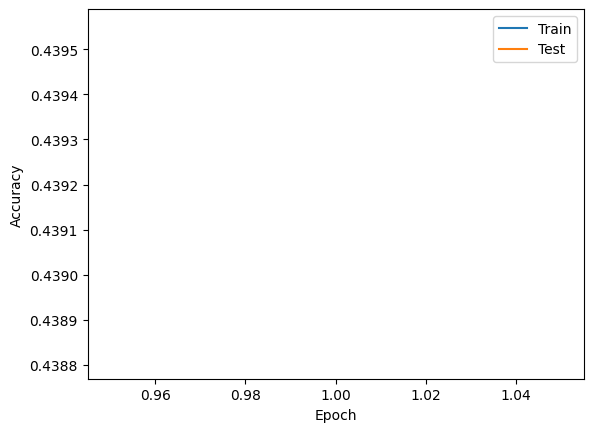

In [ ]:
print("Train accuracies:", train_accuracies)
print("Test accuracies:", test_accuracies)

x_vals = np.arange(1,epochs+1,1)
plt.plot(x_vals, train_accuracies, label="Train")
plt.plot(x_vals, test_accuracies, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()